What influence do lifestyle and genetic factors have on the severity of cancer? 
(Welchen Einfluss haben Lebensstil und genetische Faktoren auf die Schwere der Krebserkrankung?)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os

In [10]:
# Load dataset
df = pd.read_csv('./data/global_cancer_patients_2015_2024.csv')

In [ ]:
# Describe features
print(df.info())
print("Dataset overview:")
print(df.describe(include='all'))  #Mean value, standard deviation, min/max, frequency for categories

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  50000 non-null  float64
dtypes:

In [14]:
# Correlation analysis for Target_Severity_Score
def get_top_correlated_features(df, target_column, k=5):
    correlations = df.corr(numeric_only=True)[target_column].drop(target_column)
    top_features = correlations.abs().sort_values(ascending=False).head(k)
    return top_features

top_corr = get_top_correlated_features(df, target_column='Target_Severity_Score', k=5)
print("Top correlational Features with Target_Severity_Score:\n", top_corr)

Top correlational Features with Target_Severity_Score:
 Smoking               0.484420
Genetic_Risk          0.478700
Treatment_Cost_USD    0.466058
Air_Pollution         0.366963
Alcohol_Use           0.363250
Name: Target_Severity_Score, dtype: float64


In [15]:
# Detect and handle outliers using IQR
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.where((series >= lower) & (series <= upper), np.nan)

columns_to_clean = ["Obesity_Level", "Genetic_Risk", "Smoking", "Alcohol_Use", "Air_Pollution", "Target_Severity_Score"]
for col in columns_to_clean:
    df[col] = iqr_outliers(df[col])

df.dropna(subset=columns_to_clean, inplace=True)

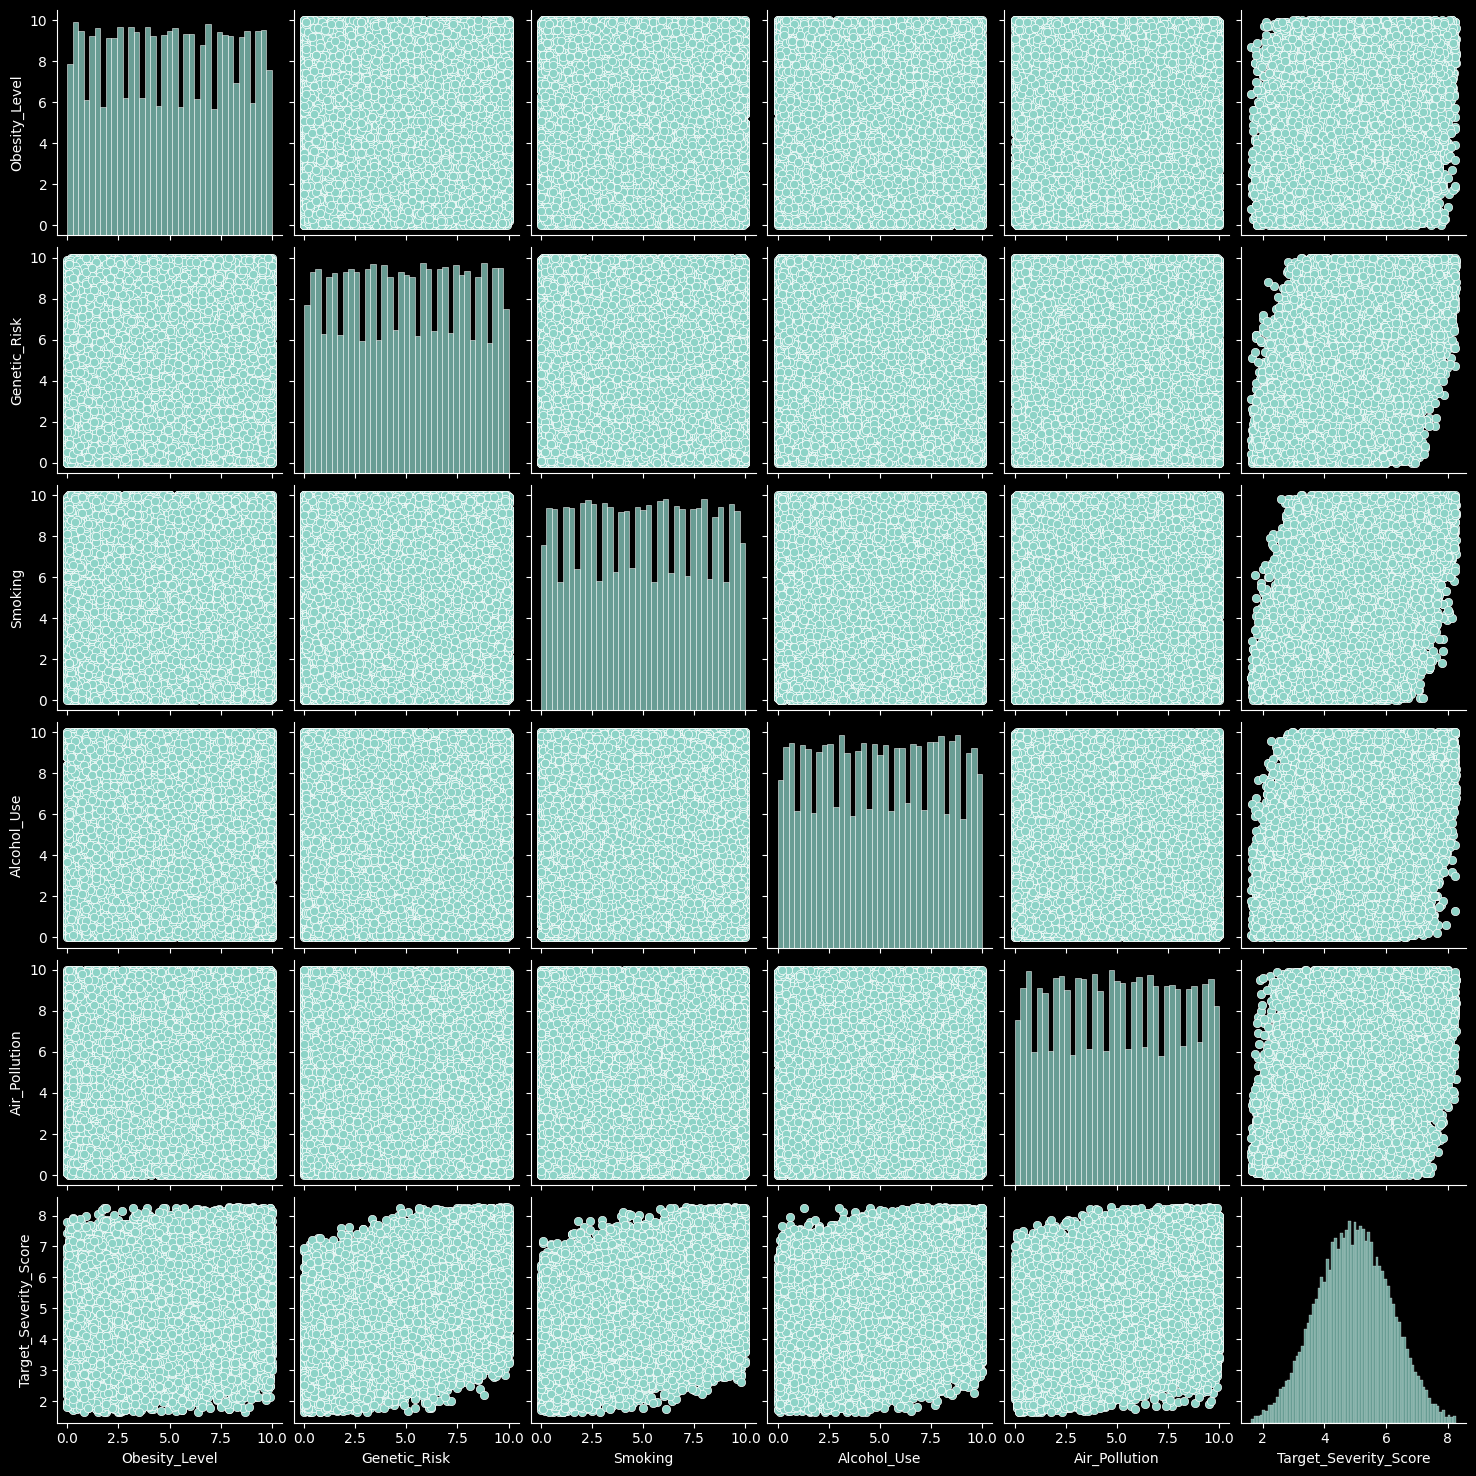

In [16]:
# Visualize pairwise relationships
sns.pairplot(df[["Obesity_Level", "Genetic_Risk", "Smoking", "Alcohol_Use", "Air_Pollution", "Target_Severity_Score"]],
             diag_kind="hist", corner=False)
plt.show()

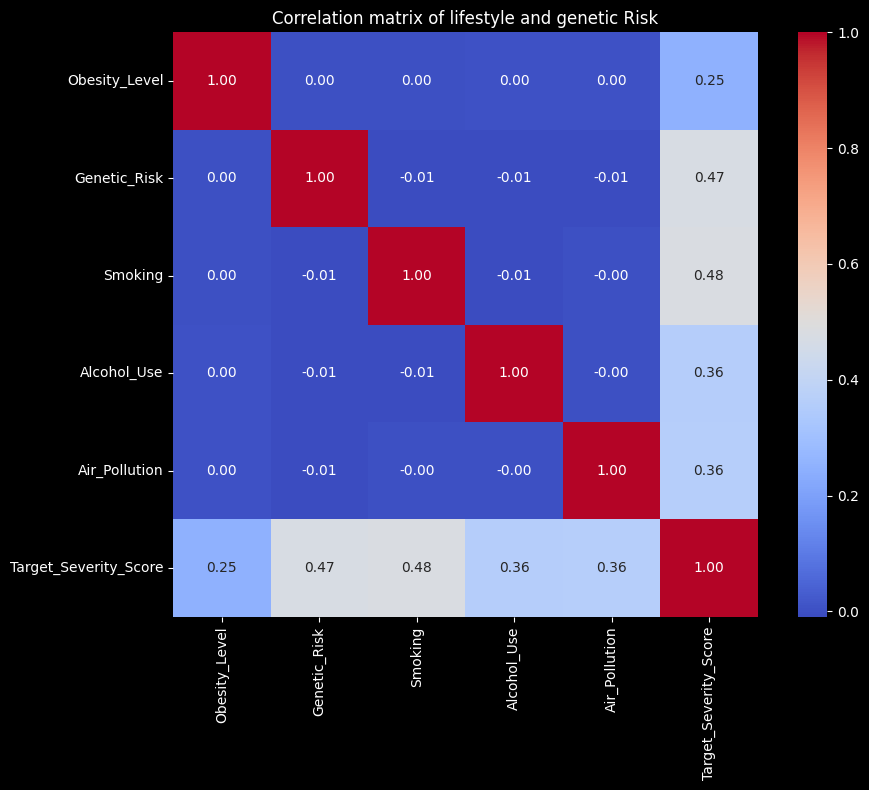

In [25]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[["Obesity_Level", "Genetic_Risk", "Smoking", "Alcohol_Use", "Air_Pollution", "Target_Severity_Score"]].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix of lifestyle and genetic Risk")
plt.tight_layout()
plt.show()

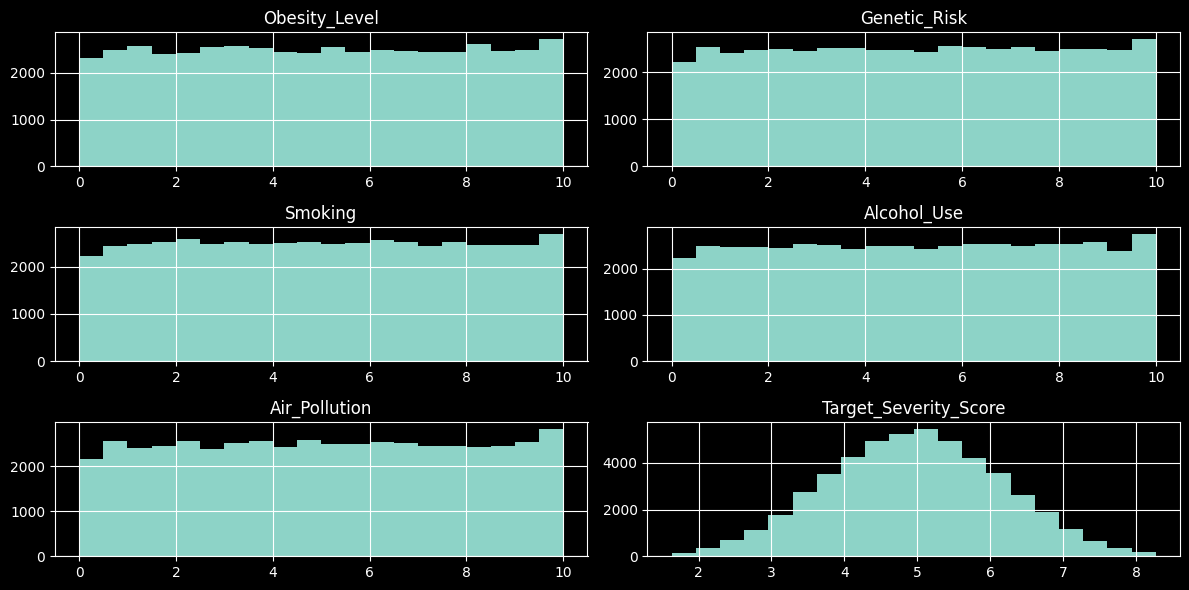

In [17]:
# Histogram plots
df[["Obesity_Level", "Genetic_Risk", "Smoking", "Alcohol_Use", "Air_Pollution", "Target_Severity_Score"]].hist(bins=20, figsize=(12, 6))
plt.tight_layout()
plt.show()

In [19]:
# Define features and target
features = ["Obesity_Level", "Genetic_Risk", "Smoking", "Alcohol_Use", "Air_Pollution"]
target = "Target_Severity_Score"

X = df[features]
y = df[target]

# Preprocessing
categorical_features = []
numeric_features = features

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_features),
    ("num", StandardScaler(), numeric_features)
])

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate model
print("Intercept:", pipeline.named_steps['regressor'].intercept_)
print("R^2 score (test set):", r2_score(y_test, pipeline.predict(X_test)))

Intercept: 4.953531535869042
R^2 score (test set): 0.785514503604383


In [20]:
# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=10)
print("10-Fold Cross-Validation R^2 Scores:", cv_scores)
print("Mean R^2 Score:", np.mean(cv_scores))

10-Fold Cross-Validation R^2 Scores: [0.78391818 0.78114007 0.78412132 0.78544372 0.78656452 0.7899394
 0.78995208 0.78778703 0.79710573 0.78700209]
Mean R^2 Score: 0.7872974138402786


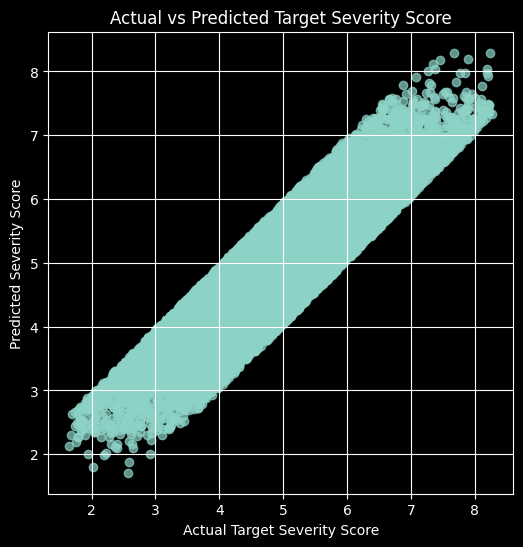

In [21]:
# Scatter plot actual vs predicted
y_pred = pipeline.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Target Severity Score")
plt.ylabel("Predicted Severity Score")
plt.title("Actual vs Predicted Target Severity Score")
plt.grid(True)
plt.show()

Zusammenfassung der Ergebnisse:

In dieser Untersuchung wurde mittels linearer Regressionsanalyse der Einfluss von Lebensstil- und genetischen Faktoren auf die Schwere einer Krebserkrankung (Target_Severity_Score) analysiert.
Als erklärende Variablen wurden Obesity_Level, Genetic_Risk, Smoking, Alcohol_Use und Air_Pollution berücksichtigt.

Nach IQR-basierter Ausreißerbehandlung und Skalierung der numerischen Merkmale wurde das Modell auf einem 75/25-Trainings-Test-Split trainiert und zusätzlich durch eine 10-fache Kreuzvalidierung evaluiert.

Das Regressionsmodell erzielte auf dem Testdatensatz einen R²-Wert von 0.7855, dies bedeutet, dass etwa 78,5 % der Varianz im Schweregrad der Erkrankung durch die gewählten Einflussfaktoren erklärt werden konnten. 
Die Kreuzvalidierung bestätigte diese Stabilität mit einem durchschnittlichen R²-Wert von 0.7873. Die Einzelwerte aller Folds lagen eng beieinander (zwischen 0.78 und 0.80).
Auch die Visualisierung der tatsächlichen versus vorhergesagten Schweregrade zeigte eine sehr hohe Übereinstimmung.



Daraus folgt die Antwort auf die Forschungsfrage (Welchen Einfluss haben Lebensstil und genetische Faktoren auf die Schwere einer Krebserkrankung?):

Die Ergebnisse zeigen eindeutig, dass sowohl Lebensstilfaktoren (wie Adipositas, Rauchen und Alkoholkonsum) als auch genetische Disposition (Genetic Risk) einen starken Einfluss auf den Schweregrad einer Krebserkrankung haben. 
Insbesondere Obesity_Level und Genetic_Risk zeigten eine hohe Korrelation mit dem Schweregrad.

Das entwickelte Regressionsmodell konnte anhand dieser Variablen den Target_Severity_Score mit hoher Genauigkeit vorhersagen. 
Die hohe erklärte Varianz und die stabilen Validierungsergebnisse lassen den Schluss zu, dass diese Merkmale relevante Prädiktoren für die individuelle schwere der Krebserkrankung darstellen.